In [17]:
from dotenv import load_dotenv 
load_dotenv()

from fourlang.text_to_4lang import TextTo4lang
from fourlang.lexicon import Lexicon
from graphviz import Source
from scripts.parse_data import read_sherliic, build_graph
from scripts.similarity import Similarity

from tqdm import tqdm
preds = []
text_to_4lang = TextTo4lang(lang="en")
data = read_sherliic("data/test.csv", ud_path="data/relation_index.tsv", keep_context=True)
data_frame = build_graph(data)

lexicon = Lexicon(lang="en")


2020-12-13 21:12:35 INFO: Downloading default packages for language: en (English)...
INFO:stanza:Downloading default packages for language: en (English)...
2020-12-13 21:12:50 INFO: File exists: /home/adaamko/stanza_resources/en/default.zip.
INFO:stanza:File exists: /home/adaamko/stanza_resources/en/default.zip.
2020-12-13 21:12:58 INFO: Finished downloading models and saved to /home/adaamko/stanza_resources.
INFO:stanza:Finished downloading models and saved to /home/adaamko/stanza_resources.
2020-12-13 21:12:58 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| sentiment | sstplus   |
| ner       | ontonotes |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
|

In [18]:
data.iloc[90]
data["prem_end"] = data["prem_end"].fillna('')
data["hypo_end"] = data["hypo_end"].fillna('')
data.iloc[90]

prem_argleft                                        B
premise                                  is reaching 
prem_argright                                       A
prem_end                                             
hypo_argleft                                        B
hypothesis                             is bringing to
hypo_argright                                       A
hypo_end                                             
score                                               0
premise_ud                     dobj^-___reach___nsubj
hypothesis_ud    pobj^-___to___prep^-___bring___nsubj
Name: 90, dtype: object

In [19]:
data['premise_text'] = data["prem_argleft"] + " " + data["premise"].apply(lambda x: x.strip()) + " " + data["prem_argright"] + data["prem_end"]

In [20]:
data['hyp_text'] = data["hypo_argleft"] + " " + data["hypothesis"].apply(lambda x: x.strip()) + " " + data["hypo_argright"] + data["hypo_end"]

In [24]:
data.iloc[0]

prem_argleft                                                     B
premise                                       is going to war with
prem_argright                                                    A
prem_end                                                          
hypo_argleft                                                     A
hypothesis                                           is hostile to
hypo_argright                                                    B
hypo_end                                                          
score                                                            1
premise_ud       pobj^-___with___prep^-___war___pobj^-___to___p...
hypothesis_ud                 nsubj^-___hostile___prep___to___pobj
premise_text                              B is going to war with A
hyp_text                                         A is hostile to B
Name: 0, dtype: object

In [25]:
import math

def asim_jac_edges_all(graph_premise, graph_hypothesises):
    """
    Asymmetric Jaccard similarity between the edges of the definition graphs
    :param graph_premise: the definition graph of the premise
    :param graph_hypothesis: the definition graph of the hypothesis
    :return: the ratio of overlapping edges per the length of the hypothesis definition
    """
    sims = []
    
    prem = set([(clear_node(s), clear_node(r), e['color'])
                for (s, r, e) in graph_premise.G.edges(data=True)])
    
    for graph_hypothesis in graph_hypothesises:
        hyp = set([(clear_node(s), clear_node(r), e['color'])
                   for (s, r, e) in graph_hypothesis.G.edges(data=True)])
        """
        hyp_cleared = []
        for triplet in hyp:
            if triplet[0].upper() != "A" and  triplet[0].upper() != "B" and triplet[1].upper() != "A" and triplet[1].upper() != "B":
                hyp_cleared.append(triplet)


        hyp = set(hyp_cleared)
        """
        sim = hyp & prem
        if not sim or len(hyp) == 0:
            sims.append(0)
        else:
            #return float(len(sim)) / math.sqrt(len(hyp))
            #return len(sim)
            sims.append(float(len(sim)) / len(hyp))
            
    return max(sims)


def asim_jac_edges(graph_premise, graph_hypothesis):
    """
    Asymmetric Jaccard similarity between the edges of the definition graphs
    :param graph_premise: the definition graph of the premise
    :param graph_hypothesis: the definition graph of the hypothesis
    :return: the ratio of overlapping edges per the length of the hypothesis definition
    """
    prem = set([(clear_node(s), clear_node(r), e['color'])
                for (s, r, e) in graph_premise.G.edges(data=True)])
    hyp = set([(clear_node(s), clear_node(r), e['color'])
               for (s, r, e) in graph_hypothesis.G.edges(data=True)])
    """
    hyp_cleared = []
    for triplet in hyp:
        if triplet[0].upper() != "A" and  triplet[0].upper() != "B" and triplet[1].upper() != "A" and triplet[1].upper() != "B":
            hyp_cleared.append(triplet)

            
    hyp = set(hyp_cleared)
    """
    sim = hyp & prem
    #print(sim)
    if not sim or len(hyp) == 0:
        return 0
    else:
        #return float(len(sim)) / math.sqrt(len(hyp))
        #return len(sim)
        return float(len(sim)) / len(hyp)

In [26]:
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words("english"))

def asim_jac_nodes(graph_premise, graph_hypothesis):
    """
    Asymmetric Jaccard similarity between the nodes of the definition graphs
    :param graph_premise: the definition graph of the premise
    :param graph_hypothesis: the definition graph of the hypothesis
    :return: the ratio of overlapping nodes per the length of the hypothesis definition
    """
    prem = set([clear_node(node) for node in graph_premise.G.nodes])
    hyp = set([clear_node(node) for node in graph_hypothesis.G.nodes])
        
    prem_cleared = [node for node in prem if node not in {"A", "B"}.union(stopwords)]
    hyp_cleared = [node for node in hyp if node not in {"A", "B"}.union(stopwords)]
    
    prem = set(prem_cleared)
    hyp = set(hyp_cleared)
    
    #print(prem)
    #print(hyp)
    
    sim = hyp & prem
    #print(sim)
    if not sim or len(hyp) == 0:
        return 0
    else:
        return float(len(sim)) / len(hyp)

In [27]:
import re
def clear_node(node):
    """
    Clears the node from the 4lang id parts
    :param node: the text to clear
    :return: the cleared text
    """
    node = re.sub(r'_[0-9][0-9]*', '', node)
    #if node in stopwords:
    #    node = "STOPWORD"
    return node

In [28]:
import networkx as nx
from networkx import algorithms
import copy

def whitelisting(graph, from_node):
    whitelist = []
    zero_graph = nx.MultiDiGraph()
    zero_graph.add_node(from_node)
    delete_list = []
    for edge in graph.G.edges(data=True):
        if not edge[2]["color"]:
            zero_graph.add_edge(edge[0], edge[1])
            

    for node in zero_graph.nodes():
        if algorithms.has_path(zero_graph, from_node, node):
            if node != from_node:
                whitelist.append(node)

    return whitelist

def blacklisting(graph):
    one_two_blacklist = ["A", "a", "b", "B"]
    for adj in graph.G._adj.values():
        #print(adj)
        for a in adj.items():
            #print(f"adj: {a[1]}")
            if {'color': 2} in a[1].values():
                new_blacklist_item = a[0]
                for node in graph.G.nodes:
                    if algorithms.has_path(graph.G, new_blacklist_item, node):
                        blacklist_node = graph.d_clean(node)
                        if blacklist_node != graph.root:
                            one_two_blacklist.append(
                                blacklist_node.split('_')[0])
                new_blacklist_item = graph.d_clean(new_blacklist_item)
                if new_blacklist_item != graph.root:
                    one_two_blacklist.append(
                        new_blacklist_item.split('_')[0])
    return one_two_blacklist


def append_zero_paths(graph):
    graph_to_return = copy.deepcopy(graph)
    edges = []
    for edge in graph.G.edges(data=True):
        X = edge[0]
        Y = edge[1]
        color = edge[2]['color']

        nodes_to_append = whitelisting(graph, Y)

        for node in nodes_to_append:
            edges.append((X, node, color))
            
        nodes_to_append = whitelisting(graph, X) 
        parent_edges = graph.G.edges(X, data=True)

        for node in nodes_to_append:
            node_edges = graph.G.edges(node, data=True)
            
            for n in parent_edges:
                n_color = n[2]["color"]
                edges.append((node, n[1], n_color))
            
            for n in node_edges:
                n_color = n[2]["color"]
                edges.append((X, n[1], n_color))
                
            parent_edges = graph.G.edges(X, data=True)

    edges = list(set(edges))
    for edge in edges:
        graph_to_return.G.add_edge(edge[0], edge[1], color=edge[2])
        
    return graph_to_return
    

## ALL HYPOTHESIS

In [57]:
### ALL HYPOTHESIS

preds = []
guesses = []
premises = []
zero_premises = []
hypothesises = []
#for i in tqdm(range(11,12)):
#for i in range(len(data_frame)):
for i in tqdm(range(len(data_frame))):
    index = i
    premise = data["premise_text"][index]
    hypothesis = data["hyp_text"][index]
    score = data.score[index]
    graph_premise = text_to_4lang.process_text(premise, method="expand", depth=2, blacklist=["in", "on", "of"], multi_definition=True, black_or_white="black", filt=False, apply_from_depth=1)
    graph_hypothesises = text_to_4lang.get_hypothesis(hypothesis)
    premises.append(graph_premise)
    hypothesises.append(graph_hypothesises)
    zero_prem = append_zero_paths(graph_premise)
    zero_premises.append(zero_prem)
    
    pred = asim_jac_edges_all(zero_prem, graph_hypothesises)
    guesses.append(pred)
    if pred >= 1.0:
        preds.append(1)
    else:
        preds.append(0)

100%|██████████| 2989/2989 [1:51:02<00:00,  2.23s/it]  


In [17]:
print(premise)

B is improving with C


## ONLY ONE HYPOTHESIS

In [33]:
preds = []
guesses = []
for i in tqdm(range(len(data_frame))):
    index = i
    score = data.score[index]
    graph_premise = zero_premises[index]
    graph_hypothesis = hypothesises[index]

    pred = asim_jac_edges(graph_premise, graph_hypothesis)
    guesses.append(pred)
    if pred >= 1.0:
        preds.append(1)
    else:
        preds.append(0)

100%|██████████| 996/996 [00:05<00:00, 185.73it/s]


In [75]:
preds = []
guesses = []
premises = []
zero_premises = []
hypothesises = []
#for i in tqdm(range(11,12)):
#for i in range(len(data_frame)):
for i in tqdm(range(len(data_frame))):
    index = i
    premise = data["premise_text"][index]
    hypothesis = data["hyp_text"][index]
    score = data.score[index]
    graph_premise = text_to_4lang.process_text(premise, method="expand", depth=2, blacklist=["in", "on", "of"], multi_definition=True, black_or_white="white", filt=False, apply_from_depth=1)
    graph_hypothesis = text_to_4lang.process_text(hypothesis, method="expand", depth=0, blacklist=["in", "on", "of"], black_or_white="black", filt=False, apply_from_depth=1)
    premises.append(graph_premise)
    hypothesises.append(graph_hypothesis)
    
    zero_prem = append_zero_paths(graph_premise)
    zero_premises.append(zero_prem)
    
    pred = asim_jac_edges(zero_prem, graph_hypothesis)
    #pred = asim_jac_edges(graph_premise, graph_hypothesis)
    guesses.append(pred)
    if pred >= 1.0:
        preds.append(1)
    else:
        preds.append(0)

100%|██████████| 2989/2989 [1:50:29<00:00,  2.22s/it]  


In [44]:
from sklearn.metrics import precision_recall_fscore_support as pr
#bPrecis, bRecall, bFscore, bSupport = pr(data_frame.score.tolist(), [1 if i>=1.0 else 0 for i in guesses])
bPrecis, bRecall, bFscore, bSupport = pr(data_frame.score.tolist(), [1 if i>=0.45 else 0 for i in guesses])

print("Precision: " +  str(bPrecis[1]))
print("Recall: " +  str(bRecall[1]))
print("Fscore: " +  str(bFscore[1]))
print(bSupport)
print([1 if i>=0.75 else 0 for i in guesses].count(1))

Precision: 0.7515723270440252
Recall: 0.24044265593561368
Fscore: 0.3643292682926829
[1995  994]
200


In [151]:
[1 if i>=0.45 else 0 for i in guesses]

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


In [9]:
text_to_4lang.lexicon.load_expanded("expanded_irtgs")

In [12]:
text_to_4lang.get_definition("overtake")

'To pass a more slowly moving object or entity.'

In [18]:
gold = data_frame.score.tolist()

In [ ]:
true_pos = []

for i, pred in enumerate(preds):
    if pred == 1 and gold[i] == 1:
        true_pos.append(i)
        
preds

In [11]:
import pickle
with open("premise_graphs", 'wb') as handle:
    pickle.dump(premises, handle,
                protocol=pickle.HIGHEST_PROTOCOL)
    
import pickle
with open("zero_premise_graphs", 'wb') as handle:
    pickle.dump(zero_premises, handle,
                protocol=pickle.HIGHEST_PROTOCOL)
    
import pickle
with open("hypothesis_graphs", 'wb') as handle:
    pickle.dump(hypothesises, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
import pickle
with open("text_irtgs", 'wb') as handle:
    pickle.dump(text_to_4lang.irtg_parse, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
import pickle
with open("text_irtgs", 'rb') as handle:
    text_to_4lang.irtg_parse = pickle.load(handle)

In [11]:
import pickle
with open("expanded_mulit_irtgs", 'wb') as handle:
    pickle.dump(text_to_4lang.lexicon.expanded_with_every_def, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
import pickle
with open("dat/expanded_mulit_irtgs", 'rb') as handle:
    text_to_4lang.lexicon.expanded_with_every_def = pickle.load(handle)

In [27]:
gold = data_frame.score.tolist()

#print(len([score for i, score in enumerate(gold) if preds[i] == 1 and score == 0]))

for i, score in enumerate(gold):
    if preds[i] == 1 and score == 0:
        print(i)

932


In [ ]:
graph_premise = text_to_4lang.process_deps(data_frame.iloc[74].premise, method="expand", depth=3, blacklist=["in", "on", "of"])
graph_hypothesis = text_to_4lang.process_deps(data_frame.iloc[74].hypothesis, method="expand", depth=1, black_or_white="black")

In [ ]:
dot_graph_premise = graph_premise.to_dot()
Source(dot_graph_premise)

In [33]:
append_zero_paths(graph_premise)

In [ ]:
dot_graph_premise = graph_premise.to_dot()
Source(dot_graph_premise)

In [ ]:
asim_jac_edges(graph_premise, graph_hypothesis)

In [ ]:
text_to_4lang.get_definition("score")

In [ ]:
67,68,72,75,76,95

In [50]:
import numpy
print("Printing float range with numpy.arange()")

thresholds = []
print("Example one")
for i in numpy.arange(0, 1, 0.05):
    thresholds.append(i)
thresholds.append(1.0)
thresholds

Printing float range with numpy.arange()
Example one


[0.0,
 0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0]

In [47]:
import numpy
print("Printing float range with numpy.arange()")

thresholds = []
print("Example one")
for i in numpy.arange(0, 10, 0.5):
    thresholds.append(i)

Printing float range with numpy.arange()
Example one


In [76]:
precisions = []
recals = []
f1_scores = []
yields = []

for thresh in thresholds:
    preds = []
    for score in guesses:
        if float(score) >= thresh:
            preds.append(1)
        else:
            preds.append(0)
    p = pr(data_frame.score.tolist(), preds)
    precisions.append(p[0][1])
    recals.append(p[1][1])
    f1_scores.append(p[2][1])
    yields.append(preds.count(1))


/home/adaamko/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


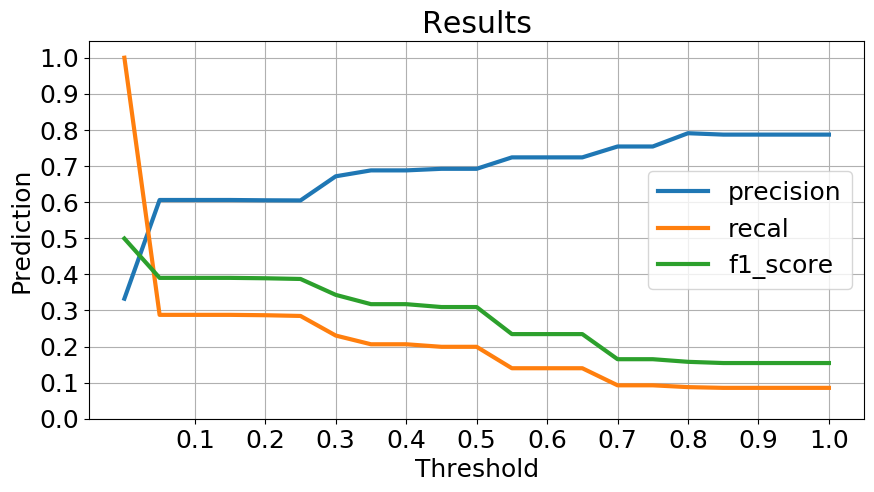

In [77]:
from matplotlib import pyplot as plt
import matplotlib

#Plotting to our canvas
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(thresholds,precisions,label='precision',linewidth=3)
plt.plot(thresholds,recals,label='recal',linewidth=3)
plt.plot(thresholds,f1_scores,label='f1_score',linewidth=3)

plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.legend()

plt.grid()
plt.xlabel('Threshold')
plt.ylabel('Prediction')
plt.title("Results")
matplotlib.rcParams.update({'font.size': 18})
#Showing what we plotted, we can see we achieved pretty good values with ~0,62 f1_score and accuracy
#Interesting thing to notice is that if we had some edge similarity, raising the threshold value doesnt change the result.
plt.show()

In [ ]:
[i for i in guesses if i>=0.8]

In [ ]:
from matplotlib import pyplot as plt
import matplotlib

#Plotting to our canvas
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(thresholds,yields,label='yield',linewidth=3)

#plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([50, 300, 1000])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.legend()

plt.grid()
plt.xlabel('Threshold')
plt.ylabel('Prediction')
plt.title("4-2 expand n/N yields")
matplotlib.rcParams.update({'font.size': 18})
#Showing what we plotted, we can see we achieved pretty good values with ~0,62 f1_score and accuracy
#Interesting thing to notice is that if we had some edge similarity, raising the threshold value doesnt change the result.
plt.show()

In [ ]:
data_frame.score.tolist().count(1)

In [ ]:
with open("state", "r+") as f:
    dist_scores = []
    next(f)
    for line in f:
        line = line.strip("\n").split("\t")
        pred = line[2]
        dist_scores.append(1 if pred=="True" else 0)

In [ ]:
bPrecis, bRecall, bFscore, bSupport = pr(data_frame.score.tolist(), dist_scores)

print("Precision: " +  str(bPrecis[1]))
print("Recall: " +  str(bRecall[1]))
print("Fscore: " +  str(bFscore[1]))

In [ ]:
guesses = []
for i in tqdm(range(len(data_frame))):
    index = i
    premise = data_frame["premise"][index]
    hypothesis = data_frame["hypothesis"][index]
    if preds[i] == 1 or dist_scores[i] == 1:
        guesses.append(1)
    else:
        guesses.append(0)

In [ ]:
bPrecis, bRecall, bFscore, bSupport = pr(data_frame.score.tolist(), guesses)

print("Precision: " +  str(bPrecis[1]))
print("Recall: " +  str(bRecall[1]))
print("Fscore: " +  str(bFscore[1]))

In [ ]:
from nltk.corpus import wordnet as wn

In [ ]:
for i in data_frame.iloc[2].premise[0]:
    if i[0] == "root":
        print(i[2][0])

In [ ]:
preds = []
for j in tqdm(range(len(data_frame))):
    index = j
    
    for i in data_frame.iloc[index].premise[0]:
        if i[0] == "root":
            premise = i[2][0]
            
    for i in data_frame.iloc[index].hypothesis[0]:
        if i[0] == "root":
            hypothesis = i[2][0]
    
    score = data_frame.score[index]
    
    hyp_syn_names_all = []
    hyper_premise_names_all = []
    
    premise_syns = wn.synsets(premise)
    hyp_syns = wn.synsets(hypothesis)
    """
    if len(premise_syns) > 0 and len(hyp_syns) > 0:
        en_premise = premise_syns[0].lemmas()[0].name()
        en_hyp = hyp_syns[0].lemmas()[0].name()
        fourlang_score = get_4lang_score(en_premise, en_hyp)
    else:
        fourlang_score = 0
    """
    
    
    for premise_syn in premise_syns:

        hyperpremise = set([i for i in premise_syn.closure(lambda s:s.hypernyms())])

        hyper_premise_lemmas = []
        for i in hyperpremise:
            lemmas = i.lemmas()
            for lemm in lemmas:
                hyper_premise_lemmas.append(lemm)

        hyper_premise_names = set([i.name() for i in hyper_premise_lemmas])
        hyper_premise_names_all += list(hyper_premise_names)
        
    for hyp_syn in hyp_syns:
        hyp_syn_lemmas = hyp_syn.lemmas()
        hyp_syn_names = set([i.name() for i in hyp_syn_lemmas])
        
        hyp_syn_names_all += list(hyp_syn_names)
    
    if (set(hyp_syn_names_all) & set(hyper_premise_names_all)):
        preds.append(1)
    else:
        preds.append(0)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as pr
bPrecis, bRecall, bFscore, bSupport = pr(data_frame.score.tolist(), preds)

print("Precision: " +  str(bPrecis[1]))
print("Recall: " +  str(bRecall[1]))
print("Fscore: " +  str(bFscore[1]))

In [ ]:
from nltk.corpus import stopwords as nltk_stopwords


In [13]:
len_defs = [len(i) for i in text_to_4lang.lexicon.lexicon_list.values()]

In [14]:
from statistics import mean, variance

In [15]:
mean(len_defs)

1.646508452520865

In [16]:
variance(len_defs)

2.7460342390470114

In [22]:
index = 949
# the method we used, printing out the found edges, it's the DEFAULT method, without using synonyms
graph_premise = text_to_4lang.process_text(data.iloc[index]["premise_text"], method="expand", depth=0, blacklist=["in", "on", "of"], filt=False, black_or_white="black", multi_definition=True, apply_from_depth=2)
zero_premise = append_zero_paths(graph_premise)
graph_hypothesises = text_to_4lang.get_hypothesis(data.iloc[index]["hyp_text"])
#append_zero_paths(graph_hypothesis)
pred = asim_jac_edges_all(zero_premise, graph_hypothesises)
#print(f"Pred of edges: {pred}")
print(f"Pred of nodes: {pred}")

{('B', 'suffer', 1), ('in', 'suffer', 1), ('in', 'C', 2), ('suffer', 'B', 0)}
{('B', 'suffer', 1), ('in', 'suffer', 1), ('in', 'C', 2), ('suffer', 'B', 0)}
{('B', 'suffer', 1), ('in', 'suffer', 1), ('in', 'C', 2), ('suffer', 'B', 0)}
{('B', 'suffer', 1), ('in', 'suffer', 1), ('in', 'C', 2), ('suffer', 'B', 0)}
{('in', 'C', 2)}
{('in', 'C', 2)}
{('in', 'C', 2)}
{('in', 'C', 2)}
Pred of nodes: 0.6666666666666666


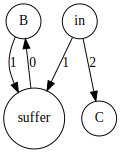

In [23]:
Source(graph_premise.to_dot())

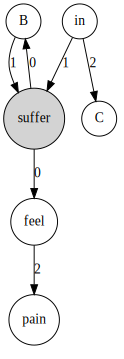

In [25]:
Source(graph_hypothesises[1].to_dot())

In [74]:
with open("fourlang_guesses_nofilt_multi_nozero", "w+") as f:
    for i in guesses:
        f.write(str(i) + "\n")